In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, BboxConnector, mark_inset
from statsmodels.distributions.empirical_distribution import ECDF
from tables import *
import os
from PIL import Image

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
def set_rcParams():
    sns.set_context('paper')
    sns.set_style('ticks')
    plt.rcParams['axes.linewidth']    = .7
    plt.rcParams['xtick.major.width'] = .5
    plt.rcParams['ytick.major.width'] = .5
    plt.rcParams['xtick.minor.width'] = .5
    plt.rcParams['ytick.minor.width'] = .5
    plt.rcParams['xtick.major.size'] = 2
    plt.rcParams['ytick.major.size'] = 2
    plt.rcParams['xtick.minor.size'] = 1
    plt.rcParams['ytick.minor.size'] = 1
    plt.rcParams['font.size']       = 8
    plt.rcParams['axes.titlesize']  = 10 
    plt.rcParams['axes.labelsize']  = 8
    plt.rcParams['legend.fontsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['figure.facecolor']=(0.5,0.5,0.5,0.5) # only affects the notebook
    plt.rcParams['savefig.facecolor']=(1,1,1,0)
    plt.rcParams["savefig.dpi"] = 1200
    plt.rcParams['font.family'] = "Arial"
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams['figure.dpi'] = 120     # only affects the notebook
set_rcParams()

In [3]:
def filter_patches(h5filename, qual_threshold, condition):
    h5file = open_file(h5filename)
    patch_table = h5file.root.patch.patchinfo
    patch_info = [[patch['filename'], patch['global_index'], patch['local_index'], patch['row_id'], patch['col_id'], 
               patch['logit'], patch['true_label']] for patch in 
               patch_table.where(condition)]
    print('Done')
    return patch_info

quality_threshold = 0.3

img_dir = '/gpfs01/berens/data/data/biobank/ukb_fundus_224/'
storage_dir = '/gpfs01/berens/user/iilanchezian/Projects/UKbiobank/supervised/patch_features/'
train_fname = os.path.join(storage_dir, 'bagnet33_patch_attributes_and_features_train_v4.h5')
val_fname = os.path.join(storage_dir, 'bagnet33_patch_attributes_and_features_val_v4.h5')
test_fname = os.path.join(storage_dir, 'bagnet33_patch_attributes_and_features_test_v4.h5')

condition1 = """(global_quality < qual_threshold) & (true_label == 1) & (predicted_label == true_label)"""
%time test_patches_male = filter_patches(test_fname, quality_threshold, condition1)

condition2 = """(global_quality < qual_threshold) & (true_label == 0) & (predicted_label == true_label)"""
%time test_patches_female = filter_patches(test_fname, quality_threshold, condition2)

Done
CPU times: user 1.83 s, sys: 2.36 s, total: 4.18 s
Wall time: 29.3 s
Done
CPU times: user 1.61 s, sys: 2.27 s, total: 3.88 s
Wall time: 23.6 s


In [4]:
data = np.load('tsne_data/tsne_batches_combined_v4.npz')

In [5]:
Z_tr, y_tr, Z_val, y_val, Z_test, y_test = (data[x] for x in data.files)

In [6]:
#Split male and female
Z_test_male = Z_test[:len(test_patches_male), :]
y_test_male = y_test[:len(test_patches_male)]

Z_test_female = Z_test[len(test_patches_male):, :]
y_test_female = y_test[len(test_patches_male):]

In [7]:
import tensorflow as tf

patch_size = int(33 * (1428 / 224))
stride = int(8 * (1428 / 224))
input_img = tf.placeholder(dtype=tf.float32, shape=(None, 1428, 1428, 3), 
                               name='input_img')
patch_extractor = tf.image.extract_patches(input_img, sizes=[1, patch_size, patch_size, 1],
                                           strides=[1, stride, stride, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
patches_tensor = tf.reshape(patch_extractor, (24*24, patch_size, patch_size, 3))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [9]:
import matplotlib.colors as mpc

def plot_tsne_partition_logits(ax, Z, y, title, v=75):
    if 'Female' in title:
        tsne_map = ax.scatter(Z[:,0], Z[:,1], c=y, s=1, cmap='coolwarm_r', edgecolors=None, rasterized=True, 
                              norm=mpc.Normalize(vmin=-1*v, vmax=v, clip=True))
    else:
        tsne_map = ax.scatter(Z[:,0], Z[:,1], c=y, s=1, cmap='coolwarm', edgecolors=None, rasterized=True,
                             norm=mpc.Normalize(vmin=-1*v, vmax=v, clip=True))
#     ax.set_aspect('equal', adjustable='box')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
#     ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return tsne_map

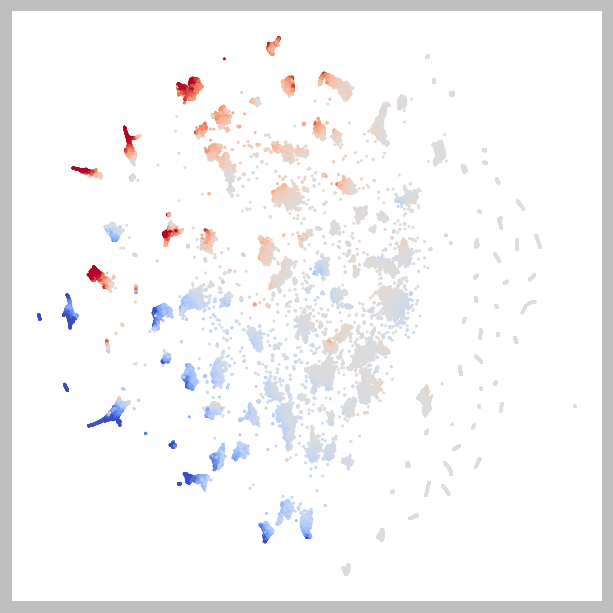

In [10]:
fig = plt.figure(figsize=(5, 5), constrained_layout=True)
gs = fig.add_gridspec(1,1) #width_ratios=[1,0.05])

ax = fig.add_subplot(gs[0])
colormap = plot_tsne_partition_logits(ax, Z_test, y_test, 'Male')

# from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
# ip = InsetPosition(ax, [1.05,0.005,0.05,0.99]) 
# ax_colorbar = fig.add_subplot(gs[0, 1])
# ax_colorbar.set_axes_locator(ip)
# fig.colorbar(colormap, cax=ax_colorbar, ticks=[], ax=ax)
# ax_colorbar.text(0.5, -0.01, 'Female', transform=ax_colorbar.transAxes, 
#     va='top', ha='center')
# ax_colorbar.text(0.5, 1.01, 'Male', transform=ax_colorbar.transAxes, 
#     va='bottom', ha='center')

# fig.set_constrained_layout_pads(w_pad=0.005, h_pad=0.005, hspace=0, wspace=0)
plt.savefig('tsne_test.pdf', dpi=600, bbox_inches='tight')

In [11]:
def plot_patches_one_cluster(gs, patches, Z, xmin, xmax, ymin, ymax, cluster_label):
    crop_left = 0.146 # ~ 300/2048
    crop_right = 0.843 # ~ 1725/2048
    crop_top = 0.032 # ~ 50/1536
    crop_bottom = 0.961 # ~ 1475/1536
    crop_size = 224 # 587 # 512

    dpi = 80
    img_dir = '/gpfs01/berens/data/data/biobank/entry23742/'
    
    inner_grid = gs.subgridspec(2, 2, wspace=0.0, hspace=0.0)
    
    plt_ind = 0
    x_condition = np.logical_and(Z[:,0]>=xmin, Z[:,0]<=xmax)
    y_condition = np.logical_and(Z[:,1]>=ymin, Z[:,1]<=ymax)
    ind = np.nonzero(np.logical_and(x_condition, y_condition))
#     print(len(ind[0]))
    random_patch_inds = np.random.choice(ind[0], 10)
    for i in random_patch_inds:
        patch = patches[i]
        patch_fname = patch[0].decode("utf-8")
        path = os.path.join(img_dir, patch_fname)
        with Image.open(path) as img:
            img = np.asarray(img)
            h, w, c = img.shape
            img = img[int(crop_top*h):int(crop_bottom*h+1),int(crop_left*w):int(crop_right*w+1),:]
            
            img = np.expand_dims(img, axis=0)
            img = img/255.
            patches_img = sess.run(patches_tensor, feed_dict={input_img:img})
            current_patch = patches_img[patch[2]]
            curr_ax = fig.add_subplot(inner_grid[plt_ind])
            curr_ax.imshow(current_patch, aspect='equal')
            curr_ax.set_xticks([])
            curr_ax.set_yticks([])
            
#             if true_label == 0:
#                 rect = matplotlib.patches.Rectangle((0, 0),current_patch.shape[0],current_patch.shape[1],
#                                                     linewidth=4,edgecolor='b',facecolor='none')
#                 curr_ax.add_patch(rect)
#             elif true_label == 1:
#                 rect = matplotlib.patches.Rectangle((0, 0),current_patch.shape[0],current_patch.shape[1],
#                                                     linewidth=4,edgecolor='r',facecolor='none')
#                 curr_ax.add_patch(rect)
            
            fig.add_subplot(curr_ax)
        if plt_ind == 0:
            curr_ax.text(-0.25,0.75, cluster_label, ha="center", 
                         transform=curr_ax.transAxes)
        plt_ind += 1

In [12]:
def get_patch_indices(patches, Z, xmin, xmax, ymin, ymax, n=2):
    x_condition = np.logical_and(Z[:,0]>=xmin, Z[:,0]<=xmax)
    y_condition = np.logical_and(Z[:,1]>=ymin, Z[:,1]<=ymax)
    ind = np.nonzero(np.logical_and(x_condition, y_condition))
    print(len(ind[0]))
    random_patch_inds = np.random.choice(ind[0], n)
    return random_patch_inds

def get_image(patches, patch_idx):
    crop_left = 0.146 # ~ 300/2048
    crop_right = 0.843 # ~ 1725/2048
    crop_top = 0.032 # ~ 50/1536
    crop_bottom = 0.961 # ~ 1475/1536
    crop_size = 224 # 587 # 512
    
    img_dir = '/gpfs01/berens/data/data/biobank/entry23742/'
    
    patch = patches[patch_idx]
    patch_fname = patch[0].decode("utf-8")
    path = os.path.join(img_dir, patch_fname)
    with Image.open(path) as img:
        img = np.asarray(img)
        h, w, c = img.shape
        img = img[int(crop_top*h):int(crop_bottom*h+1),int(crop_left*w):int(crop_right*w+1),:]
        img = np.expand_dims(img, axis=0)
        img = img/255.
        patches_img = sess.run(patches_tensor, feed_dict={input_img:img})
        current_patch = patches_img[patch[2]]
    return current_patch

1707
846


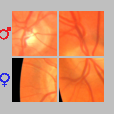

In [14]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig = plt.figure(figsize=(1, 1))
gs = fig.add_gridspec(2, 2, wspace=0.0, hspace=0.05)

male_icon = plt.imread('images/male.png')
female_icon = plt.imread('images/female.png')

male_img = OffsetImage(male_icon, zoom=0.015)
female_img = OffsetImage(female_icon, zoom=0.015)

# xmin, xmax, ymin, ymax = -79.63, -68.58, 0.04, 7.55 #M1
xmin, xmax, ymin, ymax = -67.40, -60.78, 39.09, 50.12 #M2
# xmin, xmax, ymin, ymax = -46.06, -36.34, 55.26, 61.89 #M3
# xmin, xmax, ymin, ymax = -89.23, -83.04, -11.54, -0.84 #F1
# xmin, xmax, ymin, ymax = -80.07, -64.17, -39.71, -31.32 #F2
male_patch_inds = get_patch_indices(test_patches_male, Z_test_male, xmin, xmax, ymin, ymax)
female_patch_inds = get_patch_indices(test_patches_female, Z_test_female, xmin, xmax, ymin, ymax)
with tf.Session() as sess:
    male_patch_1 = get_image(test_patches_male, male_patch_inds[0])
    male_patch_2 = get_image(test_patches_male, male_patch_inds[1])
    female_patch_1 = get_image(test_patches_female, female_patch_inds[0])
    female_patch_2 = get_image(test_patches_female, female_patch_inds[1])

    #Cluster M1
ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(male_patch_1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ab_1 = AnnotationBbox(male_img, (-0.17, 0.5), xycoords=ax1.transAxes, frameon=False)
ax1.add_artist(ab_1)

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(male_patch_2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1,0])
ax3.imshow(female_patch_1)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ab_2 = AnnotationBbox(female_img, (-0.17, 0.5), xycoords=ax3.transAxes, frameon=False)
ax3.add_artist(ab_2)

ax4 = fig.add_subplot(gs[1,1])
ax4.imshow(female_patch_2)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
# plt.savefig('F2_cluster.pdf', dpi=600)